# Model pre-training

In [184]:
# Import necessary libiraries

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from geopy import distance
from scipy.stats import norm, skew
from scipy import stats

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.metrics import mean_absolute_error

In [ ]:
# Read csv file with lat-lon coordinates

df = pd.read_csv('apartment_df_latlon.csv')
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
df = df.reset_index()

In [ ]:
# Remove 4 columns that are not needed for the model prediction

df = df.drop(columns=['Asking (tKr)', 'Agents', 'Agencies', 'Sold Dates', 'Average'])

## Missing data

In [46]:
# Check missing data
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Patio,1762,0.893509
Elevator,304,0.154158
Build year,296,0.150101
Balcony,242,0.122718
Floor number,221,0.112069
Total floor,221,0.112069
Lat,5,0.002535
Lon,5,0.002535
index,0,0.000000
Addresses,0,0.000000


In [47]:
# Remove the feature 'patio' as too many values are missing

df = df.drop(columns=['Patio'])

,index,Addresses,area (m²),# of rooms,Balcony,Elevator,Floor number,Total floor,Monthly Fees (Kr),Build year,Prices (tKr),Month,Lat,Lon
0,0,Veberödsvägen 22C,23.0,1.0,Nej,No,1,3.0,1287.0,1956.0,750,4,55.662566,13.352051
1,1,Idalavägen 47 f,50.0,2.0,NaN,No,2,2.0,4011.0,2004.0,795,10,55.621239,13.500930


## More feature engineering

In [63]:
# make a df copy

test_df = df.copy()

In [65]:
# Fill Nans to 0 as Nan means no balcony/elevator,
# then we transform "Balcony" & "Elevator" from categorical to numerical

test_df['Balcony']=test_df['Balcony'].fillna('0')
test_df['Balcony']=test_df['Balcony'].replace('Nej', '0')
test_df['Balcony']=test_df['Balcony'].replace('Ja', '1')

test_df['Elevator']=test_df['Elevator'].fillna('0')
test_df['Elevator']=test_df['Elevator'].replace('No', '0')
test_df['Elevator']=test_df['Elevator'].replace('Yes', '1')

In [68]:
# Fill Nans to 1 as Nan means the buidling has only 1 floor.

test_df['Floor number']=test_df['Floor number'].fillna('1')
test_df['Total floor']=test_df['Total floor'].fillna('1')

In [69]:
# Replace Nans to the mean value for the "Build year" and set the data type as integer

test_df['Build year']=test_df['Build year'].fillna(test_df['Build year'].mean())
test_df['Build year']=test_df['Build year'].astype(int)

In [71]:
# Replace Nans with the most common values for the lat-lon coordinates.

test_df['Lat']=test_df['Lat'].fillna(test_df['Lat'].mode()[0])
test_df['Lon']=test_df['Lon'].fillna(test_df['Lon'].mode()[0])

## Outliers

In [72]:
# Set the location of the apartment with highest sold price as reference
# and calculate the distances of the other apartments to this reference point.

length = len(test_df['Lat'])
dist = [None for _ in range(length)]

for i in range(length):
    ref = (test_df['Lat'][1971], test_df['Lon'][1971])
    coordi = (test_df['Lat'][i], test_df['Lon'][i])
    dist[i] = distance.distance(coordi, ref).km

test_df['distance'] = dist

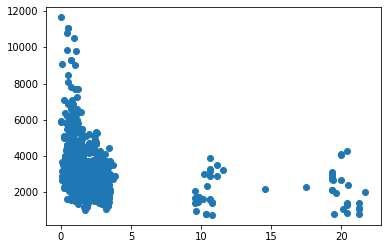

In [77]:
# Scatter plot: sold price vs distances.

plt.scatter(test_df['distance'], test_df['Prices (tKr)'])

We noticed that most data points (1919 out of 1972) are clustered within 5 km radius which display some linearities (decay as we expected). There are several apartments sold in Södra Sandby, Dalby, and Veberöd. We may treat them as outliers, delete these points and focus our model prediction within the Lund city.

In [113]:
df_city = test_df[test_df['distance']<5]
df_city.reset_index(drop=True, inplace=True)

## Data transformation

In [115]:
# Convert lat-lon to radius

radi_Lat = df_city['Lat']*math.pi/180
radi_Lon = df_city['Lon']*math.pi/180

In [116]:
# Convert radius to X, Y coordinates (neglect Z as the area is small)

R = 6371

length_city = len(df_city['Lat'])

X = [0 for _ in range(length_city)]
Y = [0 for _ in range(length_city)]

for i in range(length_city):
    X[i] = R*math.cos(radi_Lat[i])*math.cos(radi_Lat[i])
    Y[i] = R*math.cos(radi_Lon[i])*math.sin(radi_Lon[i])

In [117]:
# Scaling the coordinate data

df_city['X'] = Y
df_city['Y'] = X
pd.options.mode.chained_assignment = None  # default='warn'

df_city['X'] = df_city['X']-df_city['X'].min()
df_city['Y'] = -df_city['Y']+df_city['Y'].max()

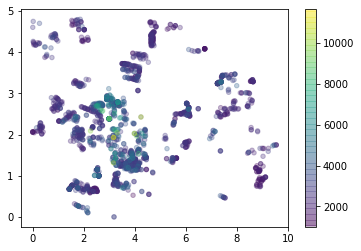

In [283]:
plt.scatter(df_city['X'],df_city['Y'],c=df_city['Prices (tKr)'], s=20, alpha=0.3,
            cmap='viridis')
plt.colorbar();

In [412]:
# Dropping lat-lon coordinates

df_city_clean = df_city.copy()
df_city_clean = df_city_clean.drop(columns=['Lat', 'Lon'])

In [414]:
# Woops! Found 2 uncleaned data!

df_city_clean['Floor number'] = df_city_clean['Floor number'].str.replace(',','.').astype(float)
df_city_clean['Total floor'] = df_city_clean['Total floor'].astype(float)
df_city_clean['Elevator'] = df_city_clean['Elevator'].replace('5 av 3', '0')

## Model training

In [415]:
# Train-test data split

cols_to_use = ['index','area (m²)', '# of rooms', 'Balcony', 'Elevator', 'Floor number', 'Total floor', 'Monthly Fees (Kr)', 'Build year', 'Month', 'distance', 'X', 'Y']
X = df_city_clean[cols_to_use]
y = df_city_clean['Prices (tKr)']
train_pre_X, test_pre_X, train_y, test_y = train_test_split(X, y, test_size=0.3)

In [416]:
train_pre_X.shape

(1343, 13)

In [417]:
test_pre_X.shape

(576, 13)

In [ ]:
# Combine train_X and train_Y into one data frame to check the correlations. 

train_df = train_pre_X.copy()
train_df['Prices (tKr)'] = train_y

In [419]:
# Do some more data transformation.

train_df['floorRatio']= train_df['Floor number']/train_df['Total floor']
test_pre_X['floorRatio']= test_pre_X['Floor number']/test_pre_X['Total floor']

train_df = train_df.drop(columns=['Floor number', 'Total floor'])
test_pre_X = test_pre_X.drop(columns=['Floor number', 'Total floor'])

train_df['index'] = train_df['index'].astype(str)
test_pre_X['index'] = test_pre_X['index'].astype(str)

train_df['Balcony'] = train_df['Balcony'].astype(int)
test_pre_X['Balcony'] = test_pre_X['Balcony'].astype(int)

train_df['Elevator'] = train_df['Elevator'].astype(int)
test_pre_X['Elevator'] = test_pre_X['Elevator'].astype(int)


<AxesSubplot:>

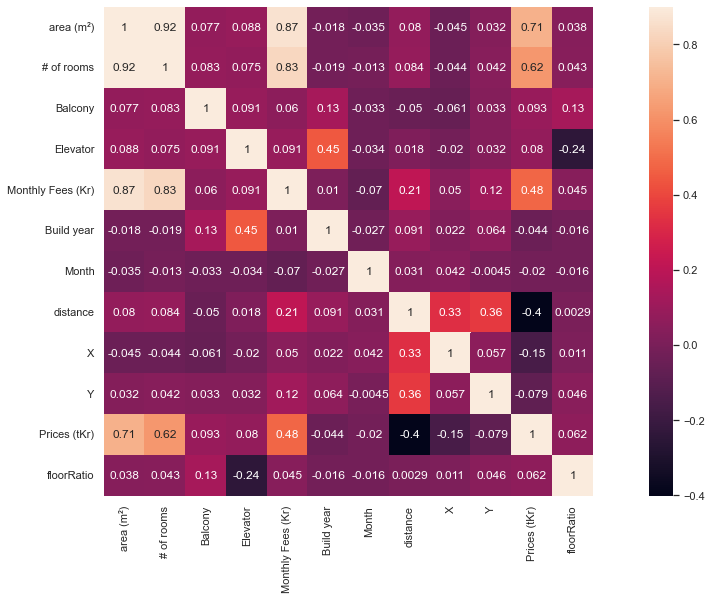

In [420]:
# Plot heatmap to check the coorelation between different features

plt.subplots(figsize=(20,9))
sns.heatmap(train_df.corr(), cbar=True, annot=True, vmax=0.9, square=True)

In [421]:
# Drop "# of rooms" and "Avgift" as they are highly correlated to apartment size

train_df= train_df.drop(columns=['# of rooms', 'Monthly Fees (Kr)'])
test_pre_X= test_pre_X.drop(columns=['# of rooms', 'Monthly Fees (Kr)'])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: 0.770440
Kurtosis: 1.195377


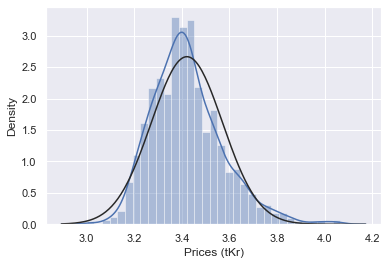

In [422]:
# Transform skewed distribution using log10

train_df['Prices (tKr)'] = np.log10(train_df['Prices (tKr)'])
# test = np.power(train_df['Prices (tKr)'], 0.0025)
# test = boxcox1p(train_df['Prices (tKr)'], 0.05)
sns.distplot(train_df['Prices (tKr)'], fit=norm)
print("Skewness: %f" % train_df['Prices (tKr)'].skew())
print("Kurtosis: %f" % train_df['Prices (tKr)'].kurt())

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: -0.411472
Kurtosis: -0.120528


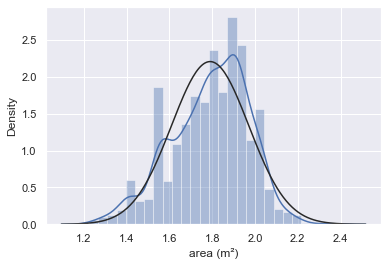

In [424]:
train_df['area (m²)'] = np.log10(train_df['area (m²)'])
# test = np.power(train_df['Prices (tKr)'], 0.0025)
# test = boxcox1p(train_df['Prices (tKr)'], 0.05)
sns.distplot(train_df['area (m²)'], fit=norm)
print("Skewness: %f" % train_df['area (m²)'].skew())
print("Kurtosis: %f" % train_df['area (m²)'].kurt())

In [425]:
# Check the skew of all numerical features

temp_df = train_df
numeric_feats = temp_df.dtypes[temp_df.dtypes != "object"].index

skewed_feats = temp_df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(20)


Skew in numerical features: 



,Skew
X,0.770137
Prices (tKr),0.769580
distance,0.572442
Elevator,0.472850
Y,0.359745
floorRatio,-0.178422
Month,-0.190101
area (m²),-0.411013
Build year,-0.482272
Balcony,-0.561480


In [ ]:
# We do similar transformation to the test data.

test_X = test_pre_X.drop(columns='index')
test_X['area (m²)'] = np.log10(test_X['area (m²)'])

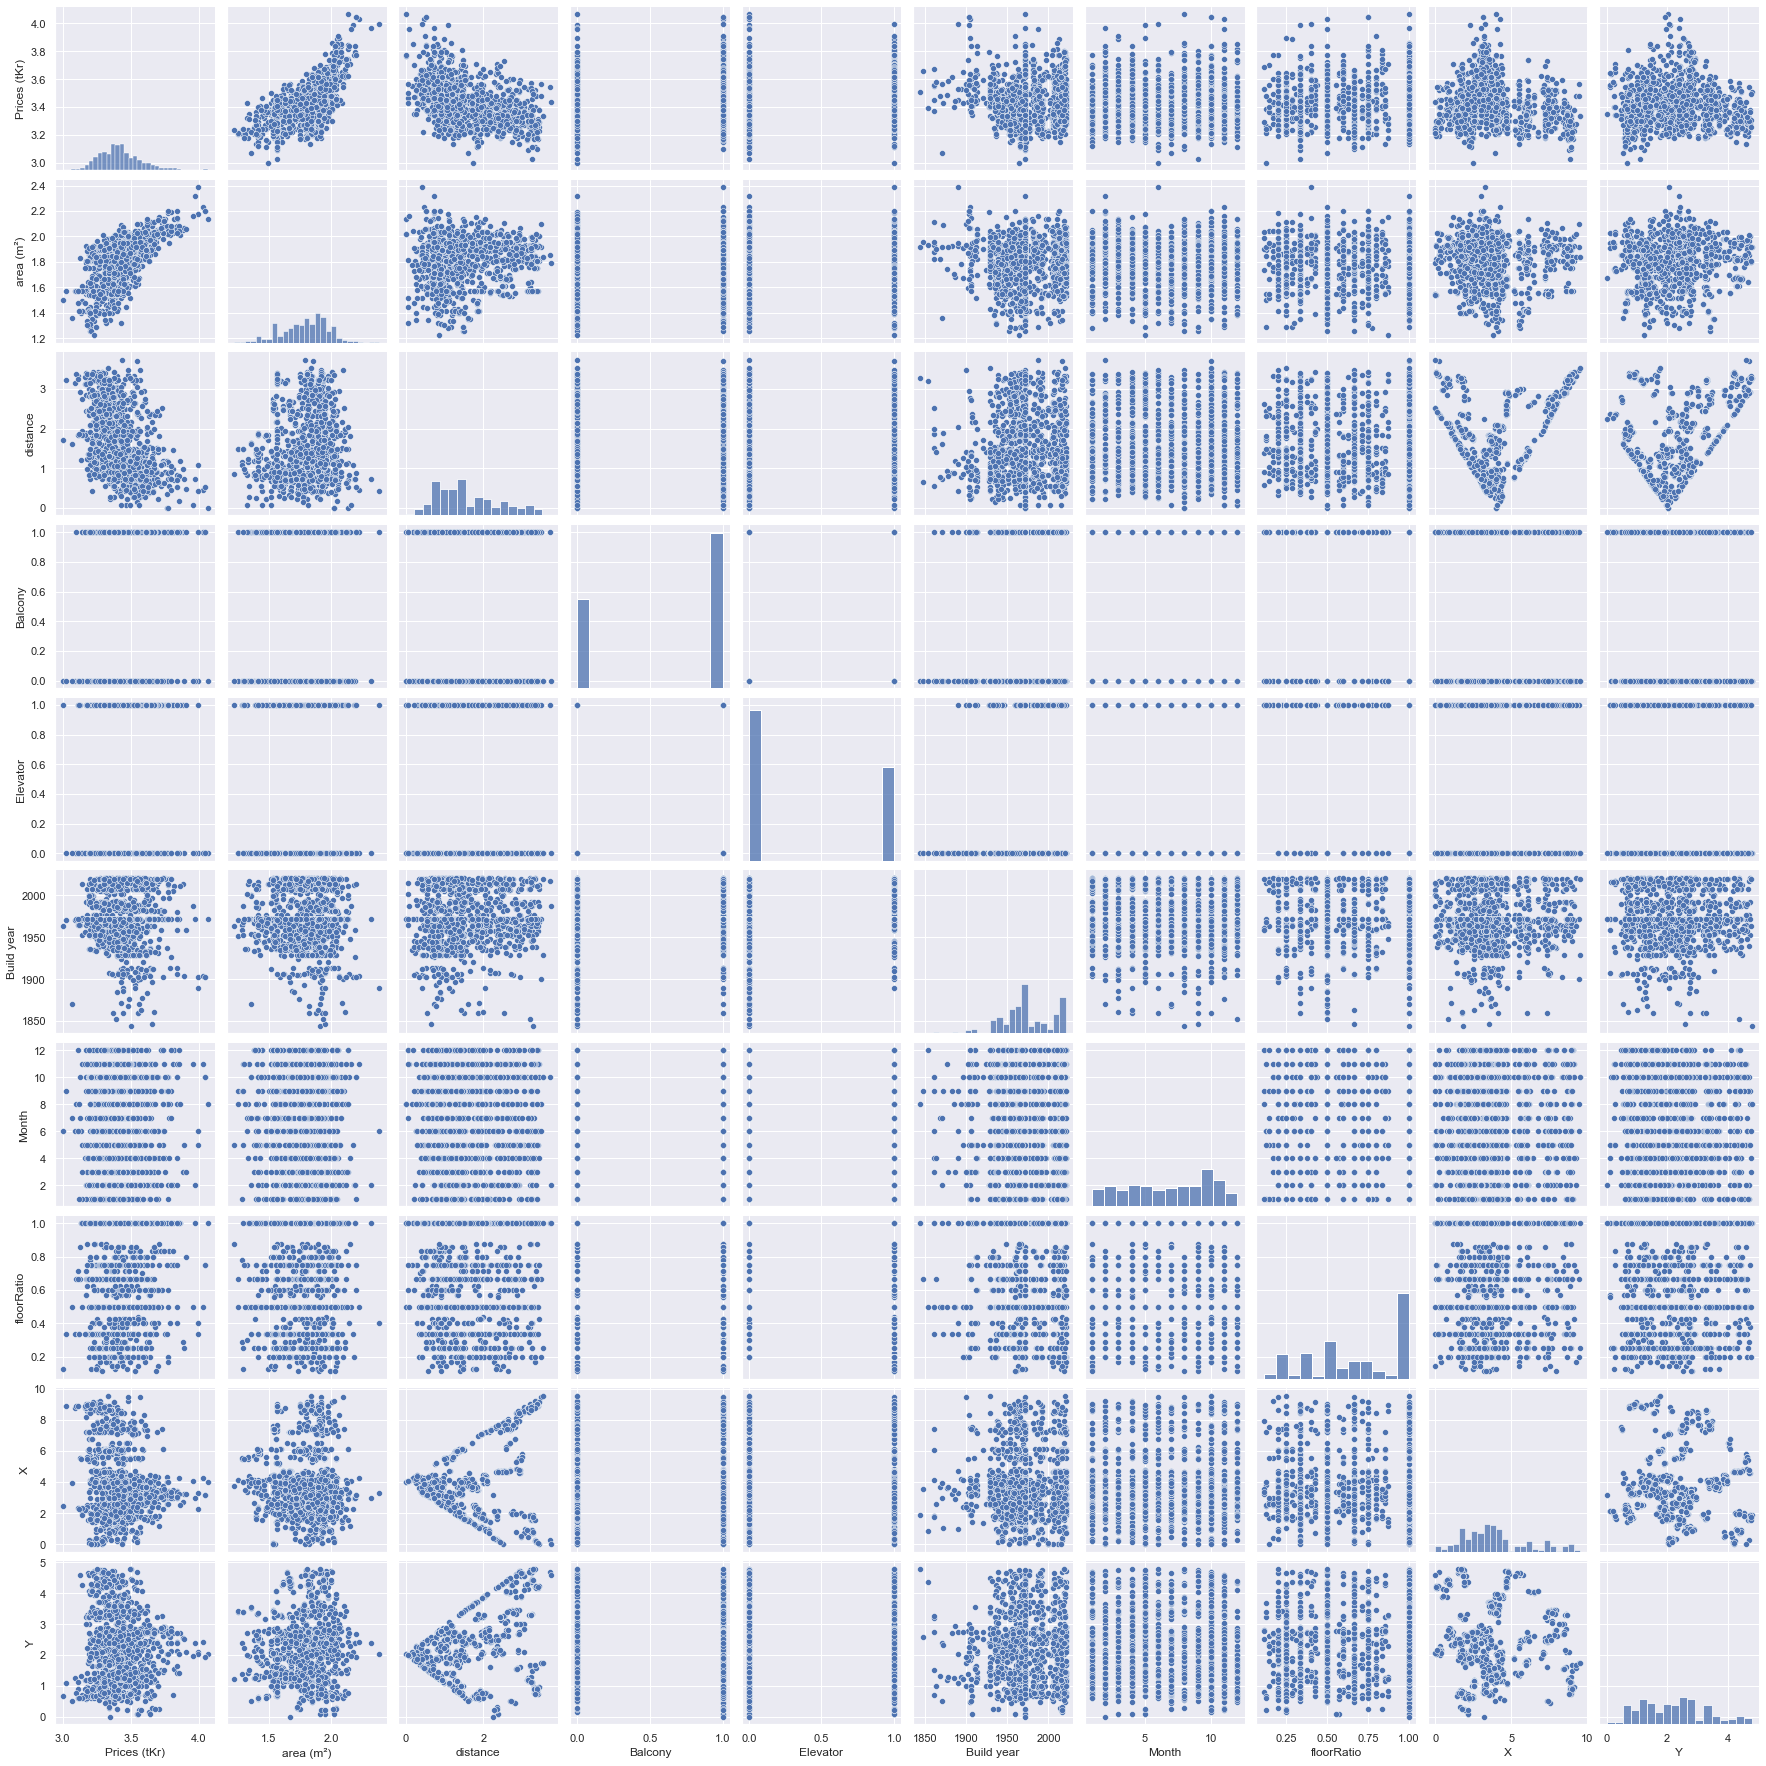

In [426]:
# Pair plot

sns.set()
cols = ['Prices (tKr)', 'area (m²)', 'distance','Balcony', 'Elevator', 'Build year', 'Month', 'floorRatio', 'X', 'Y']
sns.pairplot(train_df[cols], height=2.5)

In [434]:
# reset train_X and train_y data.

train_X = train_df.drop(columns=['Prices (tKr)','index'])
train_y = train_df['Prices (tKr)']

In [435]:
train_X.columns

Index(['area (m²)', 'Balcony', 'Elevator', 'Build year', 'Month', 'distance',
       'X', 'Y', 'floorRatio'],
      dtype='object')

In [ ]:
# From xgboost import XGBRegressor
xgb_model = XGBRegressor()
xgb_model.fit(train_X, train_y, verbose=False)
xgb_pred = xgb_model.predict(test_X)
xgb_predict = 10**xgb_pred

In [458]:
# Using random forest 
rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(train_X, train_y)
rf_pred = rf_model.predict(test_X)
rf_predict = 10 ** rf_pred

In [462]:
print("Mean Absolute Error for xgb: " + str(mean_absolute_error(xgb_predict, test_y)))
print("Mean Absolute Error for rf: " + str(mean_absolute_error(rf_predict, test_y)))

Mean Absolute Error for xgb: 277.014625761244
Mean Absolute Error for rf: 273.9269412287807


In [ ]:
# Check gradient boosting

Gboost_model = GradientBoostingRegressor()
Gboost_model.fit(train_X, train_y)
Gboost_pred = Gboost_model.predict(test_X)
Gboost_predict = 10**Gboost_pred

In [ ]:
mean_absolute_error(Gboost_predict, test_y)

286.02924602645743

In [463]:
# Test the effect of two most important features: location and size

train_simple_X = train_X.drop(columns=['Balcony', 'Elevator', 'Build year', 'Month', 
       'X', 'Y', 'floorRatio'])
test_simple_X = test_X.drop(columns=['Balcony', 'Elevator', 'Build year', 'Month', 
       'X', 'Y', 'floorRatio'])

In [464]:
train_simple_X.columns

Index(['area (m²)', 'distance'], dtype='object')

In [465]:
xgb_simple_model = XGBRegressor()
xgb_simple_model.fit(train_simple_X, train_y, verbose=False)
xgb_simple_pred = xgb_simple_model.predict(test_simple_X)
xgb_simple_predict = 10**xgb_simple_pred

rf_simple_model = RandomForestRegressor(random_state=1)
rf_simple_model.fit(train_simple_X, train_y)
rf_simple_pred = rf_simple_model.predict(test_simple_X)
rf_simple_predict = 10 ** rf_simple_pred

In [468]:
print("Mean Absolute Error for xgb_simple: " + str(mean_absolute_error(xgb_simple_predict, test_y)))
print("Mean Absolute Error for rf_simple: " + str(mean_absolute_error(rf_simple_predict, test_y)))

Mean Absolute Error for xgb_simple: 301.2202042473687
Mean Absolute Error for rf_simple: 300.63847541328437


In [469]:
orig_df = pd.read_csv('apartment_df_latlon.csv')
mean_absolute_error(orig_df['Asking (tKr)'], orig_df['Prices (tKr)'])
# orig_df.head(2)

184.65314401622717

In [472]:
Gboost_simple_model = GradientBoostingRegressor()
Gboost_simple_model.fit(train_simple_X, train_y)
Gboost_simple_pred = Gboost_simple_model.predict(test_simple_X)
Gboost_simple_predict = 10**Gboost_simple_pred
mean_absolute_error(Gboost_simple_predict, test_y)

312.32285192691677

In [478]:
# Check the mean absolute error for the asking price in the test set.

asking_test = [0 for _ in test_y]

for ind in range(len(test_y)):
    asking_test[ind] = orig_df['Asking (tKr)'][test_y.index[ind]]

mean_absolute_error(asking_test, test_y)

287.1197916666667

Apparently we could improve the model by doing the follow:

* Fine tuning the model
* More feature engineering
* Feature scalling
* dealing more outliers
* Blending prediction for different models

inherent flaw: (1) no renovation data; (2) bidding is unpredictable

In [481]:
train_X.to_csv('train_X.csv')
train_y.to_csv('train_y.csv')
test_X.to_csv('test_X.csv')
test_y.to_csv('test_y.csv')

In [ ]:
# Save model

pickle.dump(rf_model, open('hemnet_rf_pre.sav', 'wb'))

In [ ]:
rf_load = pickle.load(open('hemnet_rf_pre.sav', 'rb'))
result = rf_load.predict(test_X)
# print(10**result)